**SUMBER: https://www.kaggle.com/harlfoxem/housesalesprediction**

# Importing Modules and Files

In [254]:
# Modul - modul yang diperlukan
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np, math
from scipy.stats import skew
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Mengatur lebar dari cell agar memudahkan visualisasi dan analisis
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

data = pd.read_csv(r"C:\Users\Ezra\Documents\PURWADHIKA\Latihan - Tugas\ML\Regression\kc_house_data.csv")

print("Struktur data :")
display(data.head(1))
print("Jumlah data : ", len(data))

Struktur data :


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650


Jumlah data :  21613


**Informasi tiap variabel**
![title](var_info.png)

# Data Manipulating and Cleansing

In [255]:
# Deskripsi data
dataDesc = []
for x in data.columns:
    dataDesc.append([
        x,
        data[x].dtypes,
        data[x].isnull().sum(),
        round((((data[x].isnull().sum()) / (len(data))) * 100), 2),
        len(data[x].unique()),
        data[x].drop_duplicates().sample(2).values
    ])

print("Deskripsi masing - masing kolom :")
display(pd.DataFrame(data = dataDesc, columns = [
    "Columns Name",
    "Data Type",
    "NULL",
    "NULL Percentage",
    "Unique",
    "Unique Samples"
]))

Deskripsi masing - masing kolom :


,Columns Name,Data Type,NULL,NULL Percentage,Unique,Unique Sample
0,id,int64,0,0.0,21436,"[3343900120, 9186300060]"
1,date,object,0,0.0,372,"[20140628T000000, 20141124T000000]"
2,price,float64,0,0.0,4028,"[931000.0, 747000.0]"
3,bedrooms,int64,0,0.0,13,"[6, 3]"
4,bathrooms,float64,0,0.0,30,"[7.75, 6.75]"
5,sqft_living,int64,0,0.0,1038,"[3004, 2074]"
6,sqft_lot,int64,0,0.0,9782,"[1435, 2575]"
7,floors,float64,0,0.0,6,"[2.5, 3.0]"
8,waterfront,int64,0,0.0,2,"[0, 1]"
9,view,int64,0,0.0,5,"[1, 0]"


**Tidak ada** kolom yang memiliki missing values. Dengan begitu, tidak perlu dilakukan penyesuaian data.

Namun, ada dua kolom yang harus dimanipulasi, yaitu ***date*** dan **_price_**. Kolom tanggal harus diubah menjadi tipe _datetime_ dan memecahnya menjadi 3 kolom baru, bulan (angka), bulan (nama), serta tahun. Sedangkan, manipulasi terhadap kolom harga dilakukan dengan **membagi nilai dengan 1000** untuk memudahkan visualisasi.

In [256]:
# Manipulasi kolom 'date' menjadi tipe 'datetime' dan membuat kolom untuk hari (angka), bulan (angka), bulan (nama), serta tahun untuk keperluan analisis dan visualisasi
data["date"] = pd.to_datetime(data["date"])
data["day"] = data["date"].apply(lambda x : x.day)
data["monthInt"] = data["date"].apply(lambda x : x.month)
data["monthName"] = data["date"].apply(lambda x : x.month_name())
data["year"] = data["date"].apply(lambda x : x.year)

# Manipulasi kolom 'price'
data["price"] = data["price"].apply(lambda x : round((x / 1000), 2))

# Memubuang kolom 'date' karena sudah tidak diperlukan lagi
data.drop("date", 1, inplace = True)

print("Struktur data yang baru :")
display(data.head(1))

Struktur data yang baru :


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day,monthInt,monthName,year
0,7129300520,221.9,3,1.0,1180,5650,1.0,0,0,3,...,0,98178,47.5112,-122.257,1340,5650,13,10,October,2014


Terdapat rumah yang memiliki **33 kamar tidur**. Hal ini dirasa sangat tidak rasional. Demikian pula dengan rumah yang **tidak memiliki kamar mandi** sama sekali. Untuk rumah dengan 33 kamar tidur dirubah nilainya menjadi 3 (diasumsikan _input_ berlebih). Sedangkan, untuk rumah yang tidak memiliki kamar mandi diputuskan untuk dieliminasi karena jumlahnya pun tidak signifikan (hanya 10 rumah).

In [257]:
# Manipulasi 'bedrooms' dan eliminasi data
print("Jumlah rumah yang memiliki 33 kamar tidur :", len(data[data["bedrooms"] == 33]))
print("Jumlah rumah yang tidak memiliki kamar mandi :", len(data[data["bathrooms"] == 0]))

data.loc[data[data["bedrooms"] == 33].index, "bedrooms"] = 3
data.drop(data[data["bathrooms"] == 0].index, inplace = True)

Jumlah rumah yang memiliki 33 kamar tidur : 1
Jumlah rumah yang tidak memiliki kamar mandi : 10


Terdapat **177** data dengan 'id' yang sama, namun tanggal penjualan berbeda. Untuk mengatasi anomali ini maka diputuskan untuk mengambil data penjualan dengan **tanggal terbaru**.

In [258]:
# Mengatasi data dengan 'id' unik yang sama
print("Jumlah data dengan 'id' yang sama : ", len(data[data.duplicated("id")]))
print("\nContoh data :")
display(data[data["id"] == 6300000226])

for dataDups in data[data.duplicated("id")]["id"].unique():
    temp = data[data["id"] == dataDups]
    if len(temp["year"].unique()) == 1:
        if len(temp["monthInt"].unique()) == 1:
            data.drop(temp[temp["day"] == temp["day"].min()].index, inplace = True)
        else:
            data.drop(temp[temp["monthInt"] == temp["monthInt"].min()].index, inplace = True)
    else:
        data.drop(temp[temp["year"] == temp["year"].min()].index, inplace = True)

print("\nJumlah data baru : ", len(data))

Jumlah data dengan 'id' yang sama :  177

Contoh data :


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day,monthInt,monthName,year
20779,6300000226,240.0,4,1.0,1200,2171,1.5,0,0,3,...,0,98133,47.7076,-122.342,1130,1598,26,6,June,2014
20780,6300000226,380.0,4,1.0,1200,2171,1.5,0,0,3,...,0,98133,47.7076,-122.342,1130,1598,4,5,May,2015



Jumlah data baru :  21426


# Business Problem

Sebelum menjelajah lebih lanjut, harus dipahami terlebih dahulu bahwa ada ketimpangan data jika dilihat per tahun, dimana 2014 diisi dengan **8 bulan** dan tahun 2015 hanya **5 bulan**. Akibatnya, data tidak terdistribusi dengan normal per tahunnya.

In [259]:
# Proporsi data per tahun
yby = (pd.crosstab(data["year"], columns = "count (%)", normalize = "all") * 100).round(2)
yby.columns.names = [""]

print("Proporsi data per tahun :")
display(yby)

Proporsi data per tahun :


,count (%)
year,
2014,67.48
2015,32.52


Oleh sebab itu, untuk melihat tren akan lebih masuk akal jika menggunakan kurun waktu bulan. Ditemukan bahwa tren penjualan cukup fluktuatif, namun pada akhir periode penjualan **menurun sangat drastis**. Tren tersebut bila dilihat dari total harga penjualan juga **berjalan linear**. Hal ini dapat dibuktikan melalui rata - rata harga penjualan rumah tiap bulannya yang tidak terlalu berbeda. Artinya, tidak ada rumah dengan harga tertentu (misal di atas 1.000.000 USD) yang **menumpuk penjualannya di bulan tertentu**. Persebaran harga dirasa **sangat merata**. 

In [260]:
# Membuat data sintetis untuk menunjukkan korelasi 'price' dengan banyaknya penjualan per bulan
countPerMonth = data.groupby(["monthInt", "year"]).count().sort_values(["year", "monthInt"])[["price"]].reset_index().rename(columns = {
    "price" : "salesCount"
})

sumPrice = []
for y in [2014, 2015]:
    if y == 2014:
        for m in data.drop_duplicates(["monthName", "year"]).sort_values(["year", "monthInt"])["monthName"].unique():
            res = (data[(data["year"] == y) & (data["monthName"] == m)]["price"]).sum()
            if res > 0:
                sumPrice.append(res)
    else:
        for m in list(data.drop_duplicates(["monthName", "year"]).sort_values(["year", "monthInt"])["monthName"].unique())[-4:] + ["May"]:
            res = (data[(data["year"] == y) & (data["monthName"] == m)]["price"]).sum()
            sumPrice.append(res)

print("Nilai korelasi antara jumlah penjualan dengan total harga rumah terjual :")
priceCorr = pd.concat([countPerMonth, pd.DataFrame(sumPrice, columns = ["sumPrice"])], axis = 1)
display(priceCorr[["salesCount", "sumPrice"]].corr())

Nilai korelasi antara jumlah penjualan dengan total harga rumah terjual :


,salesCount,sumPrice
salesCount,1.000000,0.997245
sumPrice,0.997245,1.000000


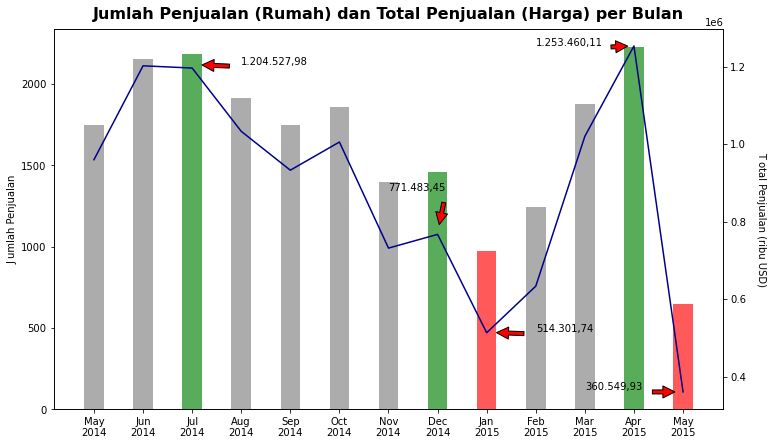

In [79]:
# Visualisasi korelasi tingkat penjualan dan rata - rata 'sqft_living'
fig, ax = plt.subplots(figsize = (12, 7))
ax.bar(data.drop_duplicates(["monthName", "year"]).sort_values(["year", "monthInt"])["monthName"].apply(lambda x : x[:3]) + "\n" + data.drop_duplicates(["monthName", "year"]).sort_values(["year", "monthInt"])["year"].astype(str),
       data.groupby(["monthInt", "year"]).count().sort_values(["year", "monthInt"])["price"],
       color = ["gray", "grey", "green", "grey", "grey", "grey", "grey", "green", "red", "grey", "grey", "green", "red"],
       alpha = 0.65,
       width = 0.4,
       linewidth = 1)

ax.set_ylabel("J umlah Penjualan")

ax.set_title("Jumlah Penjualan (Rumah) dan Total Penjualan (Harga) per Bulan", fontdict = {'fontsize': 16,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.01)

ax2 = ax.twinx()
ax2.plot(data.drop_duplicates(["monthName", "year"]).sort_values(["year", "monthInt"])["monthName"].apply(lambda x : x[:3]) + "\n" + data.drop_duplicates(["monthName", "year"]).sort_values(["year", "monthInt"])["year"].astype(str),
        sumPrice, color = "darkblue")

ax2.annotate("1.204.527,98",
            xy = ("Jul\n2014", 1205000),
            xytext = ("Aug\n2014", 1205000),
            arrowprops = {"facecolor" : "red",
                          "shrink" : 0.2})

ax2.annotate("771.483,45",
            xy = ("Dec\n2014", 771500),
            xytext = ("Nov\n2014", 880000),
            arrowprops = {"facecolor" : "red",
                          "shrink" : 0.2})

ax2.annotate("514.301,74",
            xy = ("Jan\n2015", 514301),
            xytext = ("Feb\n2015", 515000),
            arrowprops = {"facecolor" : "red",
                          "shrink" : 0.2})

ax2.annotate("1.253.460,11",
            xy = ("Apr\n2015", 1253460),
            xytext = ("Feb\n2015", 1254460),
            arrowprops = {"facecolor" : "red",
                          "shrink" : 0.2})

ax2.annotate("360.549,93",
            xy = ("May\n2015", 360549),
            xytext = ("Mar\n2015", 365549),
            arrowprops = {"facecolor" : "red",
                          "shrink" : 0.2})

ax2.set_ylabel("T otal Penjualan (ribu USD)", rotation = 270, labelpad = 20)

plt.show()

Grafik di atas menunjukkan dua hal:
1. **Penjualan yang menurun drastis (sekaligus menjadi yang terendah)** terjadi di akhir periode data.
2. Juli 2014 adalah bulan satu - satunya dimana peningkatan penjualan tidak diiringi dengan peningkatan _gross profit_ dari hasil penjualan rumah, bahkan justru menurun sekitar 11.916.830 USD. Hal ini menandakan bahwa keduanya tidak **selalu berjalan linear** (peningkatan kuantitas tidak diiringi peningkatan penghasilan penjualan). Terbuka kemungkinan pada periode berikutnya hal yang serupa dapat terjadi. Oleh sebab itu, diputuskan untuk menempatkan harga sebagai titik fokus penilaian penjualan ke depannya, **bukan kuantitas**.

# Goals

Mencari **korelasi** dan membuat **prediksi harga penjualan** untuk rumah - rumah **yang belum terjual** di King County dan Seattle berdasarkan atribut - atribut penilaian tertentu agar dapat mengetahui bagaimana **tren penjualan dan _gross profit_** di periode selanjutnya. 

# EDA

## Outliers

In [261]:
# Statistik data
print("Statistik tiap kolom :")
display(data.describe())

Statistik tiap kolom :


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day,monthInt,year
count,2.142600e+04,21426.000000,21426.000000,21426.000000,21426.000000,2.142600e+04,21426.000000,21426.000000,21426.000000,21426.000000,...,21426.000000,21426.000000,21426.000000,21426.000000,21426.000000,21426.000000,21426.000000,21426.000000,21426.000000,21426.000000
mean,4.580698e+09,541.693610,3.371605,2.118338,2082.913050,1.513510e+04,1.496080,0.007608,0.235042,3.410623,...,1971.098385,84.769346,98077.873938,47.560175,-122.213774,1988.356063,12783.860030,15.689629,6.564501,2014.325212
std,2.876734e+09,367.296425,0.904630,0.768732,918.848624,4.154734e+04,0.540157,0.086891,0.767068,0.650046,...,29.386293,402.520753,53.473018,0.138593,0.140815,685.471071,27380.226128,8.636084,3.117949,0.468465
min,1.000102e+06,78.000000,0.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000,1.000000,2014.000000
25%,2.123212e+09,324.900000,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,...,1952.000000,0.000000,98033.000000,47.471125,-122.328000,1490.000000,5100.000000,8.000000,4.000000,2014.000000
50%,3.904921e+09,450.000000,3.000000,2.250000,1920.000000,7.613500e+03,1.500000,0.000000,0.000000,3.000000,...,1975.000000,0.000000,98065.000000,47.572000,-122.230000,1840.000000,7620.000000,16.000000,6.000000,2014.000000
75%,7.308825e+09,645.000000,4.000000,2.500000,2550.000000,1.068875e+04,2.000000,0.000000,0.000000,4.000000,...,1997.000000,0.000000,98117.000000,47.678075,-122.125000,2370.000000,10085.500000,23.000000,9.000000,2015.000000
max,9.900000e+09,7700.000000,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,31.000000,12.000000,2015.000000


Dalam prediksi yang dilakukan, kolom ***price*** adalah **TARGET** yang ingin diprediksi. Sedangkan, kolom lainnya adalah **FEATURES**.
Oleh karena itu, pertama kali kita harus melihat bagaimana persebaran datanya karena langkah ini menentukan limitasi serta proses *Machine Learning* ke depannya.

***Price*** terlihat memiliki jarak yang sangat jauh antara Q3 dan nilai maksimumnya. Hal ini menandakan dua hal:
1. Harga tersentralisasi dalam rentang di bawah 800.000 - 1.000.000 USD.
2. Terdapat 'outliers' yang proporsinya tidak terlalu tinggi, namun tetap harus ditangani.

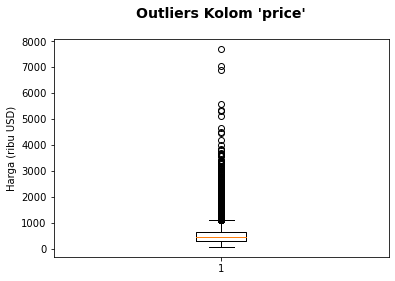

Proporsi data dengan harga lebih besar dari 1.000.000 USD :  6.8 %



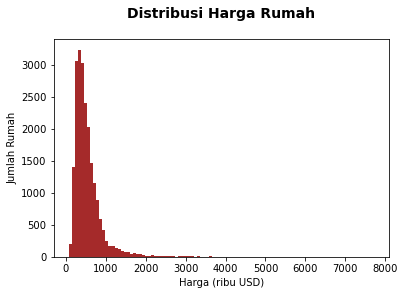

In [262]:
# Distribusi dan outliers kolom 'price'
plt.boxplot(data["price"])
plt.title("Outliers Kolom 'price'", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.07)
plt.ylabel("Harga (ribu USD)")
plt.show()

print("Proporsi data dengan harga lebih besar dari 1.000.000 USD : ", round(((len(data[data["price"] > 1000])) / len(data) * 100), 2), "%\n")

# Distribusi kolom 'price'
plt.hist(data["price"], bins = 100, color = "brown")
plt.title("Distribusi Harga Rumah", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.07)
plt.ylabel("Jumlah Rumah")
plt.xlabel("Harga (ribu USD)")
plt.show()

Harga rumah di atas 1.000.000 USD dalam hal ini menjadi _outliers_ data dengan jumlahnya terbilang tidak signifikan. Namun, diputuskan untuk membuang data - data tersebut dengan dua alasan:
1. **Memperkecil cakupan analisis**. Tidak banyaknya rumah dengan harga di atas 1.000.000 USD di King County dan Seattle menandakan permintaan dalam pasar setempat sangat sedikit. Kemungkinan besar rumah dengan harga setinggi itu **tidak cocok dengan karakter pasar dan warga setempat** (supply - demand). Sebaliknya, dari data dapat ditarik kesimpulan bahwa karakter pasar di sana berada pada rentang harga sampai dengan 1.000.000 USD. Maka dari itu, _supply_ pada rentang tersebut juga ikut bertumbuh dan bahkan bisa dikatakan terpusat. Oleh karena itu, baik dalam proses EDA maupun _machine learning_, akan hanya difokuskan pada rumah dengan **rentang harga yang 'realistis' dan banyak diminati pembeli**.

**Perlu diingat bahwa justifikasi nomor 1 tidak menggeneralisir daya beli / keuangan warga, namun menggeneralisir PASAR PERUMAHAN.**

2. Sedikit banyaknya data **mempengaruhi kemampuan mesin dalam memprediksi** harga nantinya. _Outliers_ yang proporsinya hanya **6,7%** dirasa tidak akan efektif bila dijadikan _data training_ untuk rumah di atas 1.000.000 USD. Dikhawatirkan, saat nanti _user_ memasukkan nilai _features_ yang mengarah pada harga di atas 1.000.000 USD, **mesin salah memprediksi harga dengan tingkat _error_ yang cukup tinggi**.

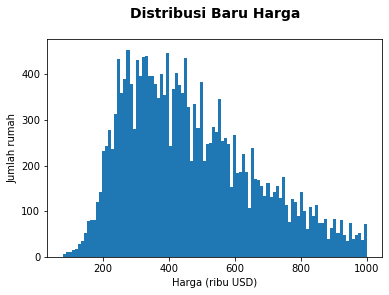

In [263]:
# Data baru
data = data[data["price"] <= 1000]

plt.hist(data["price"], bins = 100)
plt.title("Distribusi Baru Harga", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.07)
plt.xlabel("Harga (ribu USD)")
plt.ylabel("Jumlah rumah")

plt.show()

## Limitasi EDA dan _Modelling_

Hanya mampu menganalisa data dan memprediksi harga untuk rumah di King County dan Seattle dengan harga 0 - 1.000.000 USD.

## Korelasi antar kolom

In [269]:
# Skewness tiap kolom
for column in data.drop("monthName", 1).columns:
    print(column, " : ", round(skew(data[column]), 2))

id  :  0.23
price  :  0.63
bedrooms  :  0.51
bathrooms  :  0.2
sqft_living  :  0.8
sqft_lot  :  13.53
floors  :  0.69
waterfront  :  18.32
view  :  4.04
condition  :  1.03
grade  :  0.47
sqft_above  :  1.07
sqft_basement  :  1.44
yr_built  :  -0.46
yr_renovated  :  4.93
zipcode  :  0.4
lat  :  -0.42
long  :  0.88
sqft_living15  :  0.87
sqft_lot15  :  8.94
day  :  -0.01
monthInt  :  0.06
year  :  0.75


Mayoritas variabel tidak terdistribusi dengan normal. Nilai _skewness_ rata - rata berada pada kategori _moderate_ dan _severe / highly skewed_.

In [265]:
# Melihat nilai korelasi dengan metode Spearman untuk memilih kolom - kolom yang korelasinya cukup tinggi.
# Metode Spearman digunakan karena bentuk distribusi yang tidak normal.
print("Nilai korelasi dengan metode Spearman :")
display(data.corr("spearman"))

Nilai korelasi dengan metode Spearman :


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day,monthInt,year
id,1.000000,0.021504,0.016061,0.030768,0.017772,-0.115808,0.031531,0.000845,0.018389,-0.027138,...,0.032931,-0.022339,-0.002787,0.002083,0.005727,0.011462,-0.115074,0.004658,-0.009465,0.006752
price,0.021504,1.000000,0.295658,0.427935,0.578091,0.013091,0.287110,0.047064,0.202945,0.010889,...,0.090400,0.067550,0.017682,0.471049,0.071057,0.510497,0.000599,-0.019464,-0.011084,-0.000605
bedrooms,0.016061,0.295658,1.000000,0.496674,0.639345,0.201740,0.206724,-0.031436,0.034338,0.009905,...,0.182581,-0.000592,-0.164567,-0.045375,0.202132,0.424235,0.187526,-0.004680,-0.001072,-0.010041
bathrooms,0.030768,0.427935,0.496674,1.000000,0.718746,0.020930,0.539206,-0.007305,0.071839,-0.177595,...,0.597494,0.013306,-0.207049,-0.023166,0.280729,0.537335,0.016622,0.001008,0.011834,-0.030454
sqft_living,0.017772,0.578091,0.639345,0.718746,1.000000,0.273467,0.375593,0.004225,0.145304,-0.073035,...,0.366007,0.019571,-0.207414,-0.004931,0.309368,0.722217,0.253278,-0.002735,0.016950,-0.033238
sqft_lot,-0.115808,0.013091,0.201740,0.020930,0.273467,1.000000,-0.269918,0.057558,0.077892,0.127280,...,-0.061419,-0.003068,-0.303871,-0.137681,0.364571,0.327954,0.921752,0.002135,-0.000821,-0.007884
floors,0.031531,0.287110,0.206724,0.539206,0.375593,-0.269918,1.000000,-0.004204,-0.025778,-0.302212,...,0.570370,0.000154,-0.066113,0.007793,0.158766,0.282958,-0.266594,-0.002289,0.015296,-0.023682
waterfront,0.000845,0.047064,-0.031436,-0.007305,0.004225,0.057558,-0.004204,1.000000,0.204418,0.018218,...,-0.041634,0.057101,0.039726,-0.050040,-0.063485,0.008261,0.063881,0.021310,0.006671,-0.008219
view,0.018389,0.202945,0.034338,0.071839,0.145304,0.077892,-0.025778,0.204418,1.000000,0.036881,...,-0.081049,0.052423,0.095629,-0.028248,-0.106385,0.178008,0.081274,0.010283,-0.000611,0.001678
condition,-0.027138,0.010889,0.009905,-0.177595,-0.073035,0.127280,-0.302212,0.018218,0.036881,1.000000,...,-0.387138,-0.063945,-0.031580,-0.026623,-0.079018,-0.106176,0.130795,-0.001644,0.023272,-0.043328


Diputuskan untuk hanya memilih kolom dengan nilai korelasi di atas 0.2 karena nilai korelasi di bawah itu dirasa tidak signifikan. Oleh karena itu, kolom yang diambil adalah **bedrooms**, **bathrooms**, **sqft_living**, **floors**, **view**, **grade**, **sqft_above**, **sqft_basement**, **lat**, **sqft_living15**, dan tentunya **price** sebagai kolom target. Semua kolom tersebut mempunyai nilai korelasi yang **positif**, dimana harga akan cenderung naik saat variabel - variabel itu juga naik nilainya.

Korelasi terbesar berada pada variabel **grade** dengan nilai 0.59. Hal ini menandakan bahwa tingkat kualitas konstruksi dan desain adalah hal yang paling utama seorang pembeli lihat, bukan luas bangunan, pemandangan, atau bahkan jumlah lantai.

In [84]:
# Data baru
data = data[["bedrooms", "bathrooms", "sqft_living", "floors", "view", "grade", "sqft_above", "sqft_basement", "lat", "sqft_living15", "price"]]

print("Struktur data baru :")
display(data.head(1))

Struktur data baru :


,bedrooms,bathrooms,sqft_living,floors,view,grade,sqft_above,sqft_basement,lat,sqft_living15,price
0,3,1.0,1180,1.0,0,7,1180,0,47.5112,1340,221.9


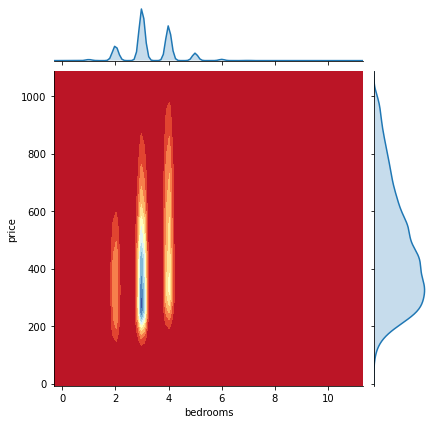

In [85]:
# Visualisasi korelasi jumlah kamar dengan harga
sns.jointplot(x = "bedrooms", y = "price", data = data, kind = "kde", cmap = "RdYlBu")
plt.show()

Persebaran jumlah kamar memang tidak begitu merata. Dapat dilihat bahwa distribusinya terpusat pada jumlah kamar 2 - 4 (dilihat dari tidak nampaknya densitas untuk jumlah kamar di atas 4). Grafik di atas sekaligus juga menunjukkan adanya pola kenaikan harga rumah seiring bertambahnya jumlah kamar (dapat dilihat dari ketebalan distribusinya yang semakin bertambah).

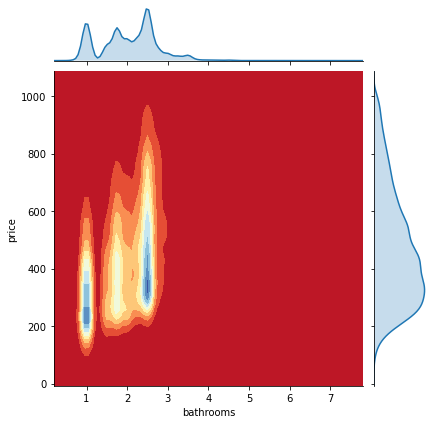

In [86]:
# Visualisasi korelasi jumlah kamar mandi dengan harga
sns.jointplot(x = "bathrooms", y = "price", data = data, kind = "kde", cmap = "RdYlBu")
plt.show()

Hal yang identik juga ditemukan pada korelasinya dengan jumlah kamar mandi. Jumlahnya terpusat pada 1 - 2.5 (.5 menunjukkan adanya toilet, namun tanpa _shower_) dan densitasnya meningkat seiring bertambahnya jumlah.

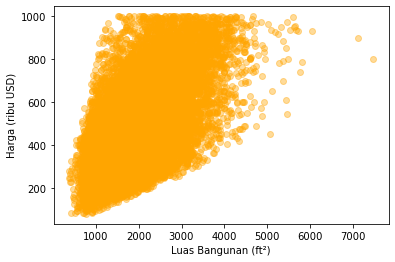

In [87]:
# Visualisasi korelasi luas bangunan dalam dengan harga
plt.scatter(data["sqft_living"], data["price"], color = "orange", alpha = 0.4)
plt.xlabel("Luas Bangunan (ft\u00B2)")
plt.ylabel("Harga (ribu USD)")

plt.show()

Korelasi positif serupa juga tercermin dalam variabel luas bangunan, dimana dari grafik dapat dilihat jika semakin luas rungannya maka harga terendahnya pun semakin naik. Densitas yang cukup sporadis menandakan bahwa harga rumah juga dikontrol oleh variabel lain.

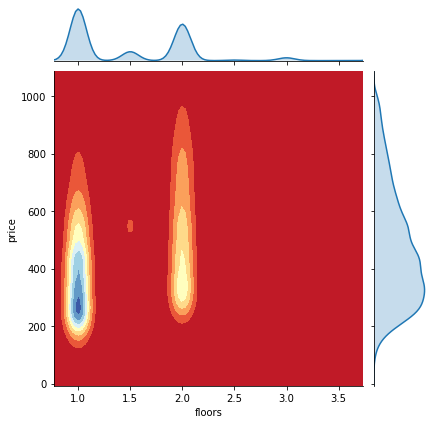

In [88]:
# Visualisasi korelasi jumlah lantai dengan harga
sns.jointplot(x = "floors", y = "price", data = data, kind = "kde", cmap = "RdYlBu")
plt.show()

Harga rumah dengan jumlah lantai yang lebih banyak cenderung memiliki harga yang lebih tinggi. Sekali lagi, hal itu dapat dibuktikan lewat panjang densitas grafik.

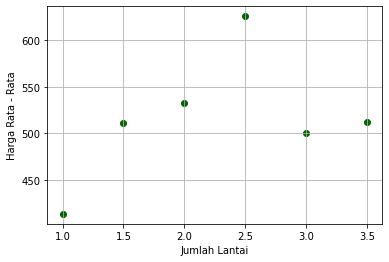

In [89]:
# Visualisasi korelasi jumlah lantai dengan rata - rata harga
plt.scatter(sorted(list(data["floors"].unique())),
           [data[data["floors"] == x]["price"].mean() for x in sorted(list(data["floors"].unique()))],
           color = "darkgreen")
plt.grid(True)
plt.xlabel("Jumlah Lantai")
plt.ylabel("Harga Rata - Rata")

plt.show()

Namun, jika kita melihat lebih jauh menggunakan harga rata - rata tiap jumlah lantai, maka ditemukan bahwa untuk rumah dengan 3 dan 3.5 lantai harga rata - ratanya lebih rendah. Artinya, meskipun variabel jumlah lantai memiliki korelasi, namun pengaruhnya tidak terlalu besar. Hal ini dapat disebabkan oleh dua hal. Pertama, rumah dengan jumlah lantai 3 - 3.5 berdiri di lahan yang jauh lebih sempit dibandingkan rumah dengan 1 - 2.5 lantai. Kedua, peminat rumah dengan lantai sebanyak itu tidak banyak karena satu dan lain hal. Akibatnya, nilai penjualan menjadi rendah.

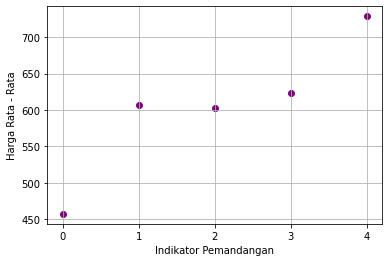

In [90]:
# Visualisasi korelasi indikator pemandangan dengan rata - rata harga
plt.scatter(sorted(list(data["view"].unique())),
           [data[data["view"] == x]["price"].mean() for x in sorted(list(data["view"].unique()))],
           color = "purple")
plt.grid(True)
plt.xlabel("Indikator Pemandangan")
plt.xticks([0, 1, 2, 3, 4])
plt.ylabel("Harga Rata - Rata")

plt.show()

Semakin bagus penilaian terhadap pemandangan suatu rumah, maka hampir bisa dipastikan harga rumah tersebut semakin mahal. Sebaliknya, rumah dengan harga murah hampir dapat dipastikan memiliki pemandangan yang cenderung buruk.

**'Hampir dapat' digunakan karena nilai harga adalah rata - rata. Bisa saja ada rumah yang nilai jualnya jauh dari harga rata - rata, namun jumlahnya tidak sebanyak rumah yang harganya dekat dengan rata - rata**

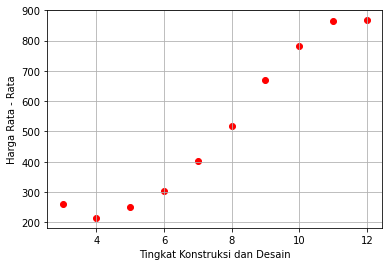

In [91]:
# Visualisasi korelasi indikator tingkat konstruksi dan desain dengan rata - rata harga
plt.scatter(sorted(list(data["grade"].unique())),
           [data[data["grade"] == x]["price"].mean() for x in sorted(list(data["grade"].unique()))],
           color = "red")
plt.grid(True)
plt.xlabel("Tingkat Konstruksi dan Desain")
plt.ylabel("Harga Rata - Rata")

plt.show()

Sama halnya dengan variabel indikator pemandangan, semakin bagus konstruksi dan desain suatu rumah maka hampir bisa dipastikan harga rumah tersebut semakin mahal. Sebaliknya, rumah dengan harga murah hampir dapat dipastikan memiliki konstruksi dan desain yang cukup buruk.

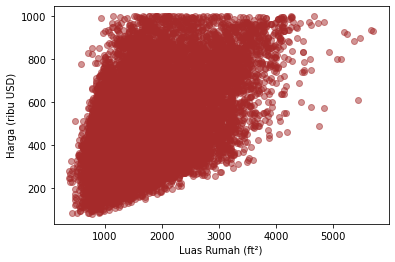

In [92]:
# Visualisasi korelasi luas rumah dengan harga
plt.scatter(data["sqft_above"], data["price"], color = "brown", alpha = 0.5)
plt.xlabel("Luas Rumah (ft\u00B2)")
plt.ylabel("Harga (ribu USD)")
plt.show()

Semakin besar luas suatu rumah, maka harga terendah rumah tersebut sudah dipastikan meningkat.

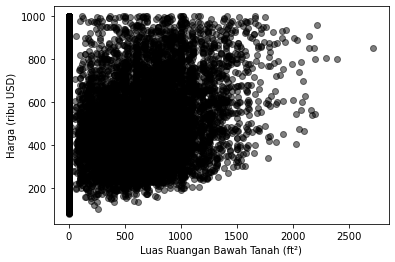

In [93]:
# Visualisasi korelasi luas ruangan bawah tanah dengan harga
plt.scatter(data["sqft_basement"], data["price"], color = "black", alpha = 0.5)
plt.xlabel("Luas Ruangan Bawah Tanah (ft\u00B2)")
plt.ylabel("Harga (ribu USD)")
plt.show()

Rumah tanpa ruang bawah tanah bukan berarti semerta - merta menjadi murah. Namun, jika rumah tersebut mempunyai ruangan bawah tanah, maka semakin besar ruangannya maka kecenderungan harganya naik semakin besar.

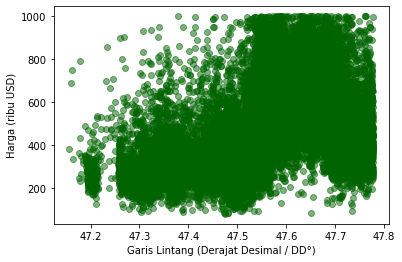

In [94]:
# Visualisasi korelasi Garis Lintang dengan harga
plt.scatter(data["lat"], data["price"], color = "darkgreen", alpha = 0.5)
plt.xlabel(u"Garis Lintang (Derajat Desimal / DD\N{DEGREE SIGN})")
plt.ylabel("Harga (ribu USD)")
plt.show()

Grafik di atas menunjukkan bahwa bilamana posisi rumah semakin ke arah Utara Amerika Serikat, maka harga akan cenderung lebih mahal. Dapat disimpulkan pula bahwa rumah yang cenderung ke arah Selatan AS lebih murah. Penyebabnya bisa berasal dari dua sumber, yaitu variabel internal lain dalam data ini atau konteks sosial - budaya - ekonomi - planologi daerah tersebut (misalnya semakin ke Utara maka daerah cenderung semakin metropolitan).

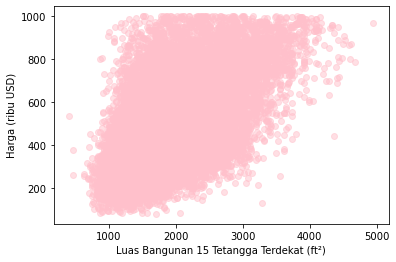

In [95]:
# Visualisasi korelasi luas bangunan 15 tetangga terdekat dengan harga
plt.scatter(data["sqft_living15"], data["price"], color = "pink", alpha = 0.5)
plt.xlabel("Luas Bangunan 15 Tetangga Terdekat (ft\u00B2)")
plt.ylabel("Harga (ribu USD)")
plt.show()

Semakin besar luas bangunan 15 tetangga terdekat dari rumah yang dijual, maka kecenderungan harganya meningkat pun semakin besar. Namun, sepertinya variabel ini tidak begitu konsisten. Misalnya, dapat dilihat pada luas sekitar 3200 ft2 yang memiliki harga terendah lebih rendah dari luas 3000 ft2.

# Modelling

In [96]:
# Splitting Data
X = data.drop("price", 1)
y = data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 7)

print("Jumlah data latih : ", len(X_train))
print("Jumlah data uji : ", len(X_test))

Jumlah data latih :  15975
Jumlah data uji :  3994


## Base Model

_Base Model_ digunakan untuk melihat algoritma mana yang kira - kira **mempunyai potensi cukup bagus** untuk memprediksi data. Nantinya, algoritma - algoritma yang punya potensi bagus itulah yang selanjutnya akan disesuaikan agar hasilnya lebih maksimal.

### Preparation

In [97]:
# Algorithms
# Linear Regression
LinReg = LinearRegression().fit(X_train, y_train)
LinRegPredTrain = LinReg.predict(X_train)
LinRegPredTest = LinReg.predict(X_test)

# Random Forest Regressor
RanFor = RandomForestRegressor().fit(X_train, y_train)
RanForPredTrain = RanFor.predict(X_train)
RanForPredTest = RanFor.predict(X_test)

# Support Vector Machine Regressor
SVM = SVR().fit(X_train, y_train)
SVMPredTrain = SVM.predict(X_train)
SVMPredTest = SVM.predict(X_test)

# K - Nearest Neighbors Regressor
KNN = KNeighborsRegressor().fit(X_train, y_train)
KNNPredTrain = KNN.predict(X_train)
KNNPredTest = KNN.predict(X_test)

# Extreme Gradient Boosting Regressor
XGB = XGBRegressor().fit(X_train, y_train)
XGBPredTrain = XGB.predict(X_train)
XGBPredTest = XGB.predict(X_test)

### Evaluation Metrics

#### Terhadap Data Latih

In [98]:
# Linear Regression
LinReg_R2 = r2_score(y_train, LinRegPredTrain)
LinReg_MAE = mean_absolute_error(y_train, LinRegPredTrain)
LinReg_MSE = mean_squared_error(y_train, LinRegPredTrain)
LinReg_RMSE = np.sqrt(LinReg_MSE)

# Random Forest Regressor
RanFor_R2 = r2_score(y_train, RanForPredTrain)
RanFor_MAE = mean_absolute_error(y_train, RanForPredTrain)
RanFor_MSE = mean_squared_error(y_train, RanForPredTrain)
RanFor_RMSE = np.sqrt(RanFor_MSE)

# Support Vector Machine Regressor
SVM_R2 = r2_score(y_train, SVMPredTrain)
SVM_MAE = mean_absolute_error(y_train, SVMPredTrain)
SVM_MSE = mean_squared_error(y_train, SVMPredTrain)
SVM_RMSE = np.sqrt(SVM_MSE)

# K - Nearest Neighbors Regressor
KNN_R2 = r2_score(y_train, KNNPredTrain)
KNN_MAE = mean_absolute_error(y_train, KNNPredTrain)
KNN_MSE = mean_squared_error(y_train, KNNPredTrain)
KNN_RMSE = np.sqrt(KNN_MSE)

# Extreme Gradient Boosting Regressor
XGB_R2 = r2_score(y_train, XGBPredTrain)
XGB_MAE = mean_absolute_error(y_train, XGBPredTrain)
XGB_MSE = mean_squared_error(y_train, XGBPredTrain)
XGB_RMSE = np.sqrt(XGB_MSE)

baseModelTrain = pd.DataFrame({
    "R2 Score" : [LinReg_R2, RanFor_R2, SVM_R2, KNN_R2, XGB_R2],
    "MAE" : [LinReg_MAE, RanFor_MAE, SVM_MAE, KNN_MAE, XGB_MAE],
    "MSE" : [LinReg_MSE, RanFor_MSE, SVM_MSE, KNN_MSE, XGB_MSE],
    "RMSE" : [LinReg_RMSE, RanFor_RMSE, SVM_RMSE, KNN_RMSE, XGB_RMSE]
}, index = ["LinReg", "RanForReg", "SVMReg", "KNNReg", "XGBoostReg"])

print("Hasil metrik evaluasi tiap algoritma (data latih):")
display(baseModelTrain)

Hasil metrik evaluasi tiap algoritma (data latih):


,R2 Score,MAE,MSE,RMSE
LinReg,0.637697,90.009747,13924.165478,118.000701
RanForReg,0.972422,23.146174,1059.901017,32.556121
SVMReg,0.380138,124.453909,23822.788005,154.346325
KNNReg,0.554929,103.236495,17105.138302,130.786614
XGBoostReg,0.898768,45.588594,3890.584868,62.374553


#### Terhadap Data Uji

In [99]:
# Linear Regression
LinReg_R2 = r2_score(y_test, LinRegPredTest)
LinReg_MAE = mean_absolute_error(y_test, LinRegPredTest)
LinReg_MSE = mean_squared_error(y_test, LinRegPredTest)
LinReg_RMSE = np.sqrt(LinReg_MSE)

# Random Forest Regressor
RanFor_R2 = r2_score(y_test, RanForPredTest)
RanFor_MAE = mean_absolute_error(y_test, RanForPredTest)
RanFor_MSE = mean_squared_error(y_test, RanForPredTest)
RanFor_RMSE = np.sqrt(RanFor_MSE)

# Support Vector Machine Regressor
SVM_R2 = r2_score(y_test, SVMPredTest)
SVM_MAE = mean_absolute_error(y_test, SVMPredTest)
SVM_MSE = mean_squared_error(y_test, SVMPredTest)
SVM_RMSE = np.sqrt(SVM_MSE)

# K - Nearest Neighbors Regressor
KNN_R2 = r2_score(y_test, KNNPredTest)
KNN_MAE = mean_absolute_error(y_test, KNNPredTest)
KNN_MSE = mean_squared_error(y_test, KNNPredTest)
KNN_RMSE = np.sqrt(KNN_MSE)

# Extreme Gradient Boosting Regressor
XGB_R2 = r2_score(y_test, XGBPredTest)
XGB_MAE = mean_absolute_error(y_test, XGBPredTest)
XGB_MSE = mean_squared_error(y_test, XGBPredTest)
XGB_RMSE = np.sqrt(XGB_MSE)

baseModelTest = pd.DataFrame({
    "R2 Score" : [LinReg_R2, RanFor_R2, SVM_R2, KNN_R2, XGB_R2],
    "MAE" : [LinReg_MAE, RanFor_MAE, SVM_MAE, KNN_MAE, XGB_MAE],
    "MSE" : [LinReg_MSE, RanFor_MSE, SVM_MSE, KNN_MSE, XGB_MSE],
    "RMSE" : [LinReg_RMSE, RanFor_RMSE, SVM_RMSE, KNN_RMSE, XGB_RMSE]
}, index = ["LinReg", "RanForReg", "SVMReg", "KNNReg", "XGBoostReg"])

print("Hasil metrik evaluasi tiap algoritma (data uji):")
display(baseModelTest)

Hasil metrik evaluasi tiap algoritma (data uji):


,R2 Score,MAE,MSE,RMSE
LinReg,0.624186,90.510359,14354.630700,119.810812
RanForReg,0.790755,62.941995,7992.357302,89.399985
SVMReg,0.371844,124.831758,23993.130229,154.897160
KNNReg,0.307835,129.300459,26438.035430,162.597772
XGBoostReg,0.785059,64.426185,8209.931424,90.608672


Dari hasil evaluasi, **_Random Forest_** adalah algoritma terbaik. Nilai *R2 Score*nya adalah yang paling tinggi dan semua nilai ***error*nya** adalah **yang terendah**. Meskipun begitu, sifatnya masih _over fitting_. Hal ini dapat dilihat dari perbedaan yang sangat signifikan antara hasil evaluasi data uji dan data latihnya. Oleh karena itu, perlu dilakukan penyesuaian lebih lanjut untuk menekan perbedaan. Sedangkan, **LinReg** terlihat cukup proporsional dengan perbedaan yang tidak signifikan antara hasil uji dan latihnya. Nilai *_R2 Score*nya pun terbilang tidak terlalu buruk dan punya potensi untuk dikembangkan lagi. SVM dan KNN pada sisi lain tidak terlalu optimal dalam kasus ini karena bersifat _bad learner_ dan _weak learner_. Diputuskan untuk tidak melanjutkan pembelajaran menggunakan keduanya dan hanya berfokus pada **_Linear Regression_**,  **_Random Forest_**, serta **XGBoost**.

## Tuned Model

### Linear Regression

#### Features Scaling

Rentang mayoritas kolom berbeda sangat signifikan. Contohnya, kolom _sqft_above_ memiliki rentang hingga ribuan sedangkan _grade_ satuan. Perbedaan rentang ini akan memberi nilai koefisien yang tidak adil (bias) sehingga besarnya pengaruh dari variabel bisa tertutup. Maka dari itu harus dilakukan _feature scaling_ untuk menyamakan rentang tiap kolom.

In [100]:
# Rentang nilai tiap kolom
print("Rentang yang tidak seimbang antar mayoritas kolom :")
display(data.head())

Rentang yang tidak seimbang antar mayoritas kolom :


,bedrooms,bathrooms,sqft_living,floors,view,grade,sqft_above,sqft_basement,lat,sqft_living15,price
0,3,1.00,1180,1.0,0,7,1180,0,47.5112,1340,221.9
1,3,2.25,2570,2.0,0,7,2170,400,47.7210,1690,538.0
2,2,1.00,770,1.0,0,6,770,0,47.7379,2720,180.0
3,4,3.00,1960,1.0,0,7,1050,910,47.5208,1360,604.0
4,3,2.00,1680,1.0,0,8,1680,0,47.6168,1800,510.0


Dalam hal ini jenis _scaling_ yang digunakan adalah _Robust Scaling_. Penggunaan jenis ini didasarkan pada bentuk distribusi _features_ data yang **tidak normal** (mayoritas berbentuk _left skewed_ dan _right skewed_). Hanya 'grade' yang bentuk distribusinya **hampir normal**. Selain itu, mayoritas _features_ juga memiliki _outliers_.

Distribusi tiap kolom yang tidak normal :


<function matplotlib.pyplot.show(*args, **kw)>

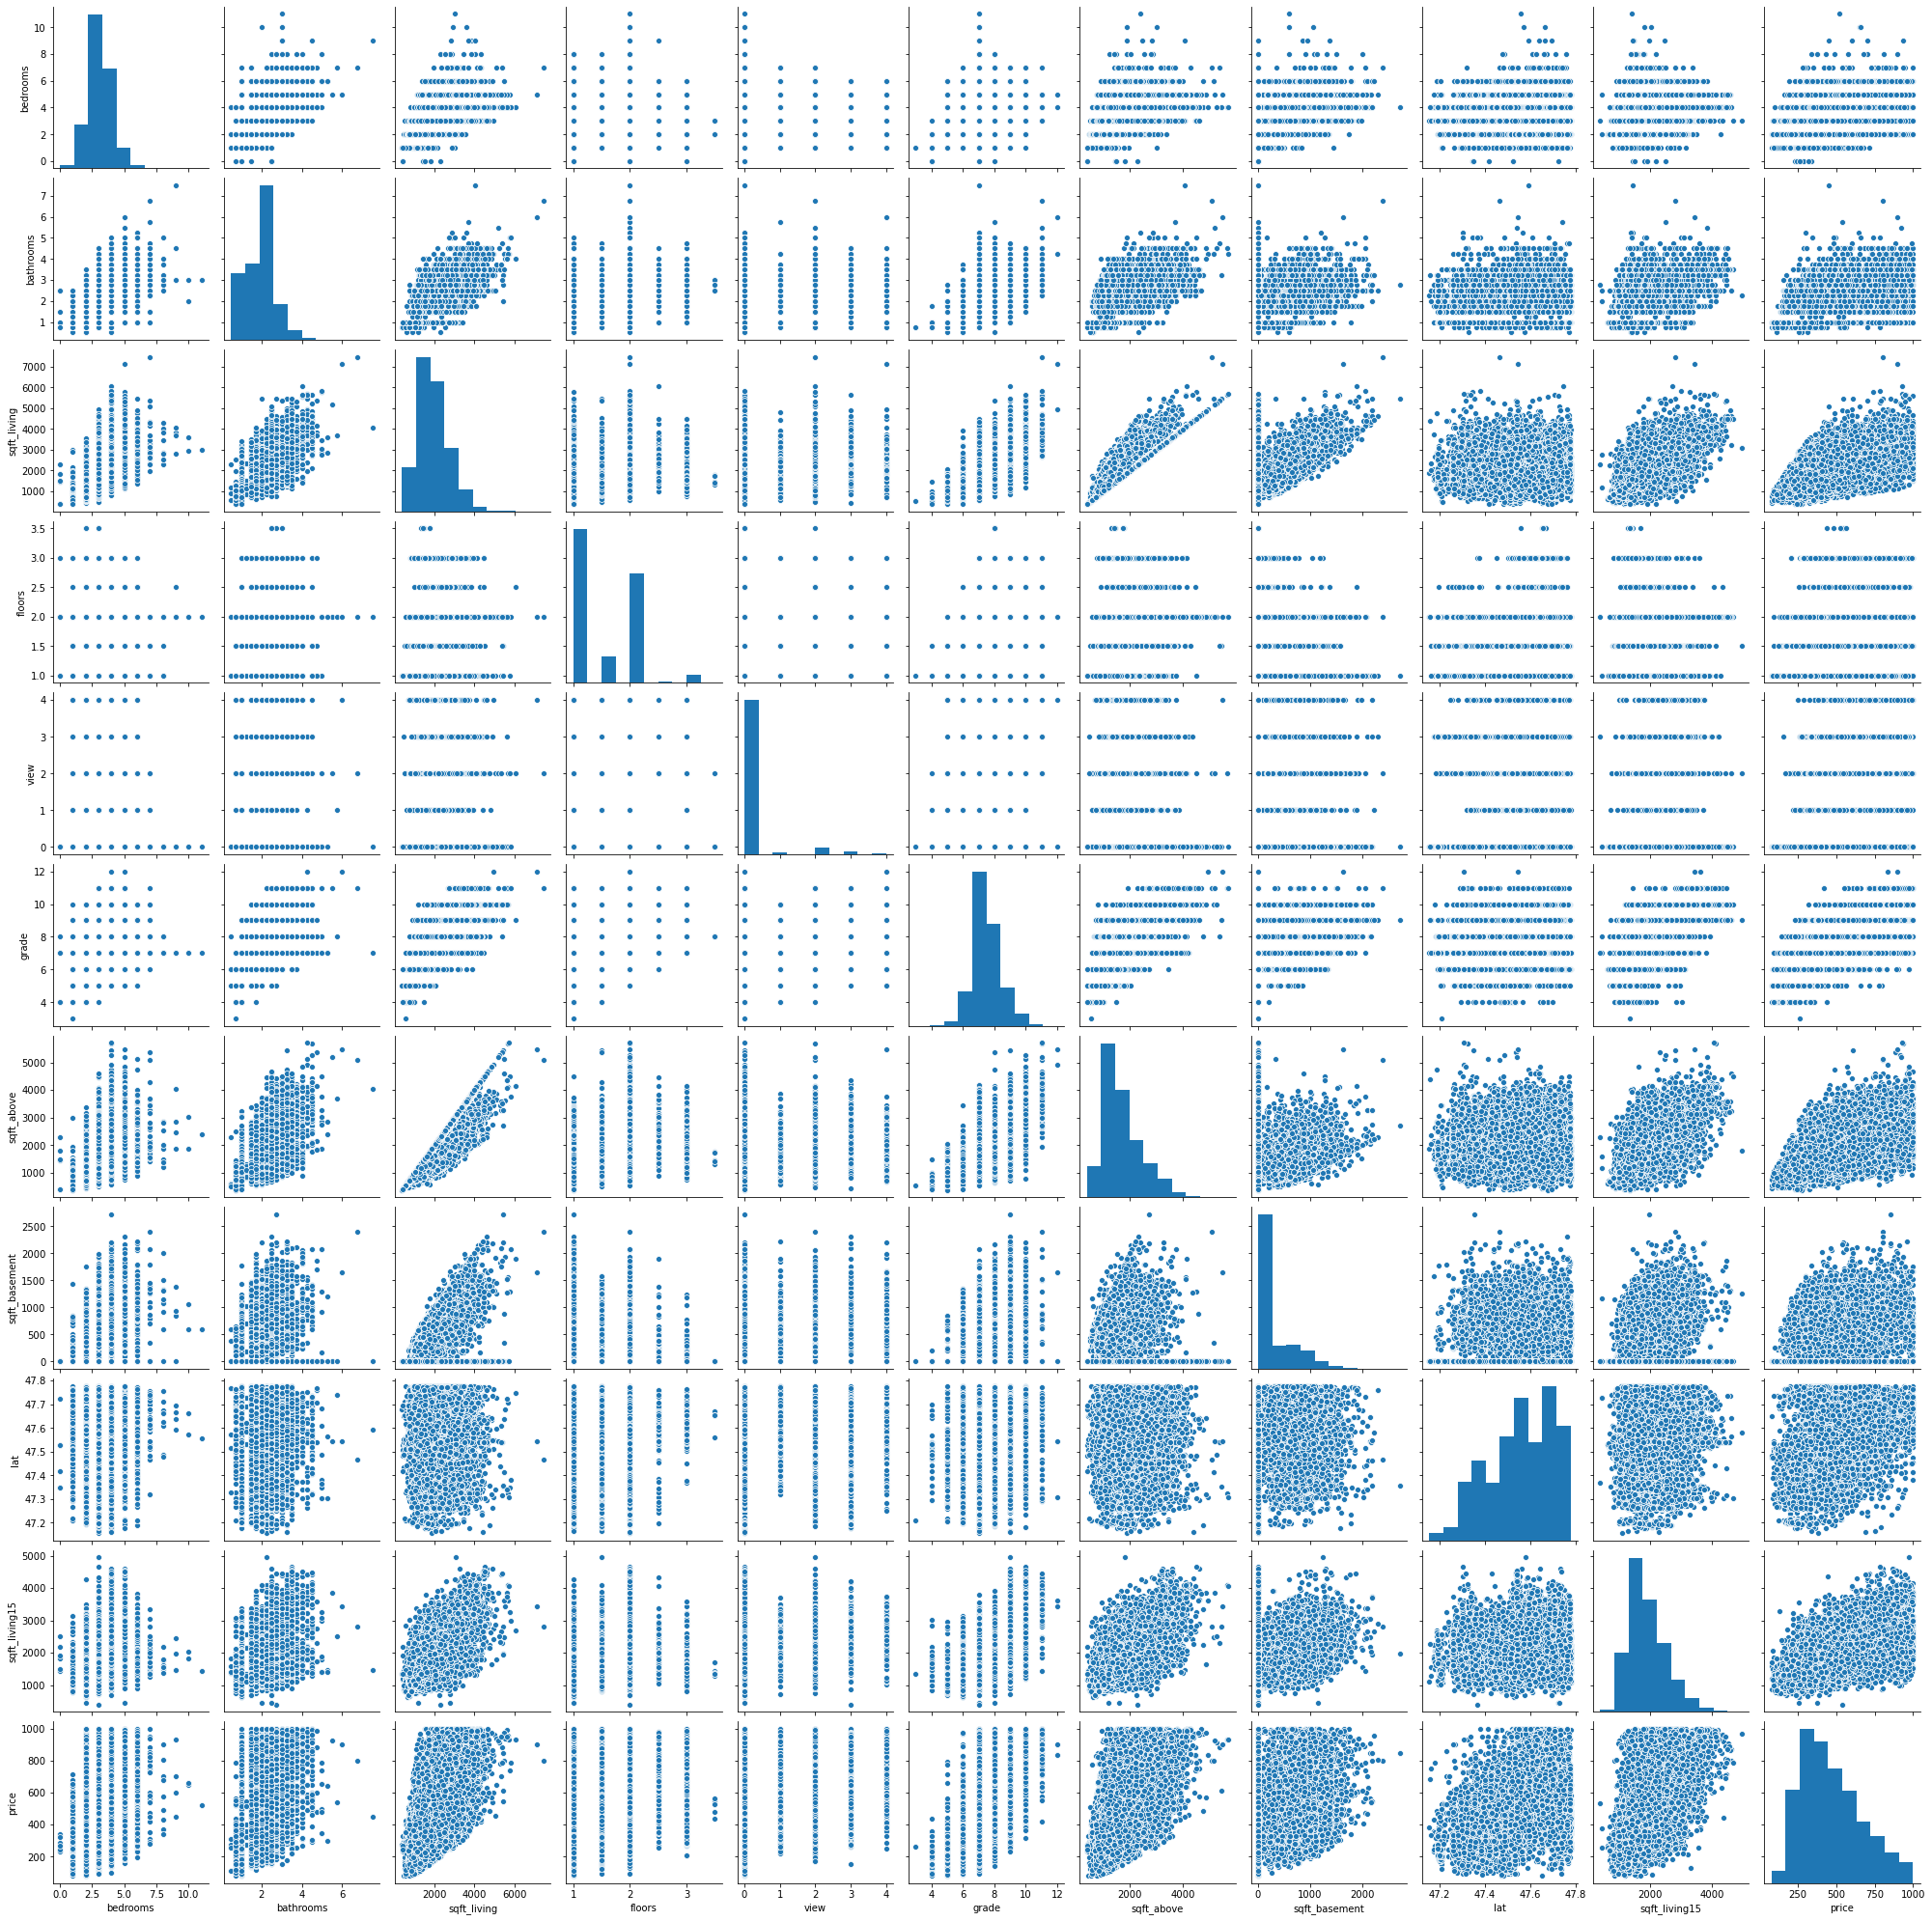

In [101]:
# Distribusi tiap kolom
print("Distribusi tiap kolom yang tidak normal :")
sns.pairplot(data)
plt.show

In [102]:
# Splitting Data
# Feature Scaling dilakukan terhadap X agar nilai X_train dan X_test saat splitting data mengikuti bentuk yang baru
XScaled = RobustScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(XScaled, y, test_size = .2, random_state = 7)

In [103]:
#Evaluation Metrics
# Preparation
LinRegScaled = LinearRegression().fit(X_train, y_train)
LinRegScaledPredTrain = LinRegScaled.predict(X_train)
LinRegScaledPredTest = LinRegScaled.predict(X_test)

# Terhadap Data Latih
LinRegScaled_R2 = r2_score(y_train, LinRegScaledPredTrain)
LinRegScaled_MAE = mean_absolute_error(y_train, LinRegScaledPredTrain)
LinRegScaled_MSE = mean_squared_error(y_train, LinRegScaledPredTrain)
LinRegScaled_RMSE = np.sqrt(LinRegScaled_MSE)

LinRegScaledTrain = pd.DataFrame({
    "R2 Score" : [LinRegScaled_R2],
    "MAE" : [LinRegScaled_MAE],
    "MSE" : [LinRegScaled_MSE],
    "RMSE" : [LinRegScaled_RMSE]
}, index = ["LinRegScaledTrain"])

# Terhadap Data Uji
LinRegScaled_R2 = r2_score(y_test, LinRegScaledPredTest)
LinRegScaled_MAE = mean_absolute_error(y_test, LinRegScaledPredTest)
LinRegScaled_MSE = mean_squared_error(y_test, LinRegScaledPredTest)
LinRegScaled_RMSE = np.sqrt(LinRegScaled_MSE)

LinRegScaledTest = pd.DataFrame({
    "R2 Score" : [LinRegScaled_R2],
    "MAE" : [LinRegScaled_MAE],
    "MSE" : [LinRegScaled_MSE],
    "RMSE" : [LinRegScaled_RMSE]
}, index = ["LinRegScaledTest"])

print("Hasil metrik evaluasi LinReg yang sudah di scaling:")
display(pd.concat([LinRegScaledTrain, LinRegScaledTest]))

Hasil metrik evaluasi LinReg yang sudah di scaling:


,R2 Score,MAE,MSE,RMSE
LinRegScaledTrain,0.637697,90.028112,13924.190675,118.000808
LinRegScaledTest,0.624173,90.528750,14355.156790,119.813008


Terdapat kenaikan _R2 Score_ dan penurunan pada semua nilai _error_. Namun, kenaikan tersebut tergolong sangat kecil. Maka itu akan dilakukan _feature engineering_ lainnya untuk memaksimalkan model, yaitu dengan ***Polynomial***.

#### Features Transformation

In [142]:
# Splitting Data
XPoli = PolynomialFeatures(degree = 3, include_bias = False).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(XPoli, y, test_size = .2, random_state = 7)

In [105]:
#Evaluation Metrics
# Preparation
LinRegPoli = LinearRegression().fit(X_train, y_train)
LinRegPoliPredTrain = LinRegPoli.predict(X_train)
LinRegPoliPredTest = LinRegPoli.predict(X_test)

# Terhadap Data Latih
LinRegPoli_R2 = r2_score(y_train, LinRegPoliPredTrain)
LinRegPoli_MAE = mean_absolute_error(y_train, LinRegPoliPredTrain)
LinRegPoli_MSE = mean_squared_error(y_train, LinRegPoliPredTrain)
LinRegPoli_RMSE = np.sqrt(LinRegPoli_MSE)

LinRegPoliTrain = pd.DataFrame({
    "R2 Score" : [LinRegPoli_R2],
    "MAE" : [LinRegPoli_MAE],
    "MSE" : [LinRegPoli_MSE],
    "RMSE" : [LinRegPoli_RMSE]
}, index = ["LinRegPoliTrain"])

# Terhadap Data Uji
LinRegPoli_R2 = r2_score(y_test, LinRegPoliPredTest)
LinRegPoli_MAE = mean_absolute_error(y_test, LinRegPoliPredTest)
LinRegPoli_MSE = mean_squared_error(y_test, LinRegPoliPredTest)
LinRegPoli_RMSE = np.sqrt(LinRegPoli_MSE)

LinRegPoliTest = pd.DataFrame({
    "R2 Score" : [LinRegPoli_R2],
    "MAE" : [LinRegPoli_MAE],
    "MSE" : [LinRegPoli_MSE],
    "RMSE" : [LinRegPoli_RMSE]
}, index = ["LinRegPoliTest"])

print("Hasil metrik evaluasi LinReg Polynomial Degree 3:")
display(pd.concat([LinRegPoliTrain, LinRegPoliTest]))

Hasil metrik evaluasi LinReg Polynomial Degree 3:


,R2 Score,MAE,MSE,RMSE
LinRegPoliTrain,0.715087,79.416692,10949.895336,104.641748
LinRegPoliTest,0.688368,81.665627,11903.141920,109.101521


Polynomial dengan _degree_ 3 adalah model Polynomial terbaik. Terhadap data latih, _R2 Score_ naik 0.08 diikuti dengan penurunan MAE sebesar 11 poin. Nilai _error_ lainnya juga ikut menurun. Hal yang sama juga terjadi terhadap data uji, dimana _R2 Score_ naik 0.06 dan semua nilai _error_ menurun. Sifat evaluasi juga dirasa sudah proporsional dengan perbedaan _R2 Score_ data uji dan latih yang hanya sebesar 0.026.

**Sebenarnya, _degree_ 4 dan 6 memiliki nilai _R2 Score_ untuk data latih yang lebih tinggi.Namun, hal itu diikuti juga dengan sifatnya yang _overfitting_.**

_Degree_ 1:
![title](linreg_poly1.jpg)
_Degree_ 2:
![title](linreg_poly2.jpg)
_Degree_ 4:
![title](linreg_poly4.jpg)
_Degree_ 5:
![title](linreg_poly5__.jpg)
_Degree_ 6:
![title](linreg_poly6.jpg)
_Degree_ 7:
![title](linreg_poly7__.jpg)

#### Multi Features Engineering

Tingkat _error_ dirasa masih bisa ditekan. Maka dari itu, dilakukan penggabungan dua _feature engineering_ di atas untuk memaksimalkan model. Penggabungan ini dilakukan dengan mengkuadratkan hasil X yang sudah di _scaling_. _Scaling_ dilakukan terlebih dahulu karena jika hasil _polynomial_ yang disamakan rentang antar *features*nya, maka esensi dari _polynomial_ yang membuat garis non - linear akan hilang (semua nilai yang sudah dikuadratkan akan mempunyai rentang yang sama).

**Proses mana yang dilakukan terlebih dahulu (_scaling_ sebelum _polynomial_ ataupun sebaliknya) tidak terlalu berpengaruh pada hasil evaluasi (perbedaan sangat amat kecil).**

In [162]:
# Splitting Data
XScaledPoli = PolynomialFeatures(degree = 3, include_bias = False).fit_transform(XScaled)
X_train, X_test, y_train, y_test = train_test_split(XScaledPoli, y, test_size = .2, random_state = 7)

In [163]:
# Evaluation Metrics
# Preparation
LinRegScaledPoli = LinearRegression().fit(X_train, y_train)
LinRegScaledPoliPredTrain = LinRegScaledPoli.predict(X_train)
LinRegScaledPoliPredTest = LinRegScaledPoli.predict(X_test)

# Terhadap Data Latih
LinRegScaledPoli_R2 = r2_score(y_train, LinRegScaledPoliPredTrain)
LinRegScaledPoli_MAE = mean_absolute_error(y_train, LinRegScaledPoliPredTrain)
LinRegScaledPoli_MSE = mean_squared_error(y_train, LinRegScaledPoliPredTrain)
LinRegScaledPoli_RMSE = np.sqrt(LinRegScaledPoli_MSE)

LinRegScaledPoliTrain = pd.DataFrame({
    "R2 Score" : [LinRegScaledPoli_R2],
    "MAE" : [LinRegScaledPoli_MAE],
    "MSE" : [LinRegScaledPoli_MSE],
    "RMSE" : [LinRegScaledPoli_RMSE]
}, index = ["LinRegScaledPoliTrain"])

# Terhadap Data Uji
LinRegScaledPoli_R2 = r2_score(y_test, LinRegScaledPoliPredTest)
LinRegScaledPoli_MAE = mean_absolute_error(y_test, LinRegScaledPoliPredTest)
LinRegScaledPoli_MSE = mean_squared_error(y_test, LinRegScaledPoliPredTest)
LinRegScaledPoli_RMSE = np.sqrt(LinRegScaledPoli_MSE)

LinRegScaledPoliTest = pd.DataFrame({
    "R2 Score" : [LinRegScaledPoli_R2],
    "MAE" : [LinRegScaledPoli_MAE],
    "MSE" : [LinRegScaledPoli_MSE],
    "RMSE" : [LinRegScaledPoli_RMSE]
}, index = ["LinRegScaledPoliTest"])

print("Hasil metrik evaluasi LinReg Robust Scaler - Polynomial Degree 3:")
display(pd.concat([LinRegScaledPoliTrain, LinRegScaledPoliTest]))

Hasil metrik evaluasi LinReg Robust Scaler - Polynomial Degree 3:


,R2 Score,MAE,MSE,RMSE
LinRegScaledPoliTrain,0.773783,69.761182,8694.049300,93.241886
LinRegScaledPoliTest,0.741427,73.114670,9876.486126,99.380512


Sejauh ini, hasil penggabungan _feature engineering_ di atas **menjadi yang terbaik**. Nilai _R2 Score_ melonjak drastis diikuti dengan penurunan yang drastis juga untuk semua nilai *error*nya. Proporsi antara hasil data uji dan latihnya juga masih tergolong proporsional, ditambah lagi dengan nilai _R2 Score_ yang nyaris mendekati 0.8.

**Dapat disimpulkan bahwa model ini masuk dalam kategori _good learner_.**

### Random Forest Regressor

Secara parsial, _base model Random Forest_ untuk data uji sudah cukup bagus. Namun, perbedaannya sangat signifikan dengan data latihnya sehingga menjadi _over fitting_. Selain itu, hasil evaluasi data latihnya pun hampir masuk dalam kategori _strong learner_. Hal ini tentunya tidak baik karena selain _to good to be true_, _R2 Score_ yang sangat mendekati 1 akan cenderung mempunyai model pembelajaran yang menghafal. Akibatnya jika ada data baru yang nilainya jauh berbeda dari data latih, model akan kesulitan memprediksinya. Oleh sebab itu, dilakukan _hyper parameter tuning_ untuk dapat memaksimalkan model. Memaksimalkan dalam hal ini adalah dengan melakukan _bagging_ evaluasi data latih hingga menjadi ***good learner***.

**Hyper Parameter Tuning**

In [170]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 7)

In [176]:
# Preparation
# RanForTuned = GridSearchCV(
#     estimator = RandomForestRegressor(),
#     param_grid = {
#         "n_estimators" : [100, 200, 500],
#         "max_depth" : [None, 5, 7],
#         "min_samples_split" : [2, 9, 15],
#         "min_samples_leaf" : [1, 2, 5],
#         "max_features" : [None, 3, 5]
#         }, cv = 4, n_jobs = -1, verbose = 1
#     )

# RanForTuned.fit(X_train, y_train)

Fitting 4 folds for each of 243 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 42.9min finished


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 7],
                         'max_features': [None, 3, 5],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 9, 15],
                         'n_estimators': [100, 200, 500]},
             verbose=1)

In [181]:
# Best Param
print("Parameter terbaik dari Random Forest Regressor - Tuned:")
display(RanForTuned.best_params_)

Parameter terbaik dari Random Forest Regressor - Tuned:


{'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'n_estimators': 500}

In [182]:
# Evaluation Metrics
bestRanForTuned = RanForTuned.best_estimator_
bestRanForTunedPredTrain = bestRanForTuned.predict(X_train)
bestRanForTunedPredTest = bestRanForTuned.predict(X_test)

# Terhadap Data Latih
bestRanForTuned_R2 = r2_score(y_train, bestRanForTunedPredTrain)
bestRanForTuned_MAE = mean_absolute_error(y_train, bestRanForTunedPredTrain)
bestRanForTuned_MSE = mean_squared_error(y_train, bestRanForTunedPredTrain)
bestRanForTuned_RMSE = np.sqrt(bestRanForTuned_MSE)

bestRanForTunedTrain = pd.DataFrame({
    "R2 Score" : [bestRanForTuned_R2],
    "MAE" : [bestRanForTuned_MAE],
    "MSE" : [bestRanForTuned_MSE],
    "RMSE" : [bestRanForTuned_RMSE]
}, index = ["bestRanForTunedTrain"])

# Terhadap Data Uji
bestRanForTuned_R2 = r2_score(y_test, bestRanForTunedPredTest)
bestRanForTuned_MAE = mean_absolute_error(y_test, bestRanForTunedPredTest)
bestRanForTuned_MSE = mean_squared_error(y_test, bestRanForTunedPredTest)
bestRanForTuned_RMSE = np.sqrt(bestRanForTuned_MSE)

bestRanForTunedTest = pd.DataFrame({
    "R2 Score" : [bestRanForTuned_R2],
    "MAE" : [bestRanForTuned_MAE],
    "MSE" : [bestRanForTuned_MSE],
    "RMSE" : [bestRanForTuned_RMSE]
}, index = ["bestRanForTunedTest"])

print("Hasil metrik evaluasi model terbaik Random Forest Regressor - Tuned:")
display(pd.concat([bestRanForTunedTrain, bestRanForTunedTest]))

Hasil metrik evaluasi model terbaik Random Forest Regressor - Tuned:


,R2 Score,MAE,MSE,RMSE
bestRanForTunedTrain,0.933534,36.329268,2554.454551,50.541612
bestRanForTunedTest,0.798364,61.882283,7701.711224,87.759394


_Bagging_ berhasil dilakukan dengan adanya penurunan _R2 Score_ terhadap data latih sebesar 0.04. Hasil _R2 Score_ untuk data uji juga naik, meskipun hanya sedikit. Namun, model ini tetap masih bersifat _over fitting_. Perbedaan antara keduanya masih sangat jauh.

**_Tuning_ untuk membuat hasil evaluasi menjadi proporsional diputuskan tidak dilanjutkan. Hal ini didasari performa laptop yang kurang memadai sehingga membutuhkan waktu yang cukup lama. Akan tetapi, tidak menutup kemungkinan untuk memperbaiki model dalam beberapa waktu mendatang.**

### XGBoost Regressor

Model ini memiliki kondisi yang sama dengan _Random Forest Regressor base model_. Oleh karena itu, perlu dilakukan _bagging_ dengan _hyper parameter tuning_ agar hasil evaluasi antara data latih dan uji lebih proporsional.

**Hyper Parameter Tuning**

Oleh karena model ini bersifat **_tree based_** (https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d#:~:text=XGBoost%20is%20a%20decision%2Dtree,uses%20a%20gradient%20boosting%20framework.&text=The%20algorithm%20differentiates%20itself%20in,and%20user%2Ddefined%20prediction%20problems.), maka _scaling_ untuk menurunkan nilai _error_ tidak bisa dilakukan. Maka itu, pendekatan langsung menggunakan _hyper parameter tuning_.

In [231]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 7)

In [234]:
# Preparation
# XGBTuned = GridSearchCV(
#     estimator = XGBRegressor(),
#     param_grid = {
#         "max_depth" : [6, 7],
#         "learning_rate" : [.2, .3],
#         "n_estimator" : [100, 300],
#         "gamma" : [0, .1],
#         "colsample_bytree" : [1, 2],
#         "subsample" : [1, 2],
#         "reg_alpha" : [0, 1],
#         "reg_lambda" : [1, 2]}, cv = 3, n_jobs = -1, verbose = 1
#     )

# XGBTuned.fit(X_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  2.0min finished


[00:53:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [235]:
# Best Param
print("Parameter terbaik dari Random Forest Regressor - Tuned:")
display(XGBTuned.best_params_)

Parameter terbaik dari Random Forest Regressor - Tuned:


{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 6,
 'n_estimator': 100,
 'reg_alpha': 1,
 'reg_lambda': 2,
 'subsample': 1}

In [237]:
# Evaluation Metrics
bestXGBTuned = XGBTuned.best_estimator_
bestXGBTunedPredTrain = bestXGBTuned.predict(X_train)
bestXGBTunedPredTest = bestXGBTuned.predict(X_test)

# Terhadap Data Latih
bestXGBTuned_R2 = r2_score(y_train, bestXGBTunedPredTrain)
bestXGBTuned_MAE = mean_absolute_error(y_train, bestXGBTunedPredTrain)
bestXGBTuned_MSE = mean_squared_error(y_train, bestXGBTunedPredTrain)
bestXGBTuned_RMSE = np.sqrt(bestXGBTuned_MSE)

bestXGBTunedTrain = pd.DataFrame({
    "R2 Score" : [bestXGBTuned_R2],
    "MAE" : [bestXGBTuned_MAE],
    "MSE" : [bestXGBTuned_MSE],
    "RMSE" : [bestXGBTuned_RMSE]
}, index = ["bestXGBTunedTrain"])

# Terhadap Data Uji
bestXGBTuned_R2 = r2_score(y_test, bestXGBTunedPredTest)
bestXGBTuned_MAE = mean_absolute_error(y_test, bestXGBTunedPredTest)
bestXGBTuned_MSE = mean_squared_error(y_test, bestXGBTunedPredTest)
bestXGBTuned_RMSE = np.sqrt(bestXGBTuned_MSE)

bestXGBTunedTest = pd.DataFrame({
    "R2 Score" : [bestXGBTuned_R2],
    "MAE" : [bestXGBTuned_MAE],
    "MSE" : [bestXGBTuned_MSE],
    "RMSE" : [bestXGBTuned_RMSE]
}, index = ["bestXGBTunedTest"])

print("Hasil metrik evaluasi model terbaik XGBoost Regressor - Tuned:")
display(pd.concat([bestXGBTunedTrain, bestXGBTunedTest]))

Hasil metrik evaluasi model terbaik XGBoost Regressor - Tuned:


,R2 Score,MAE,MSE,RMSE
bestXGBTunedTrain,0.877836,49.693434,4695.044555,68.520395
bestXGBTunedTest,0.793310,63.254466,7894.755441,88.852436


_R2 Score_ data uji berhasil diturunkan sebesar 0.02. Dengan begitu, _bagging_ berhasil dilakukan meskipun sangat belum maksimal. Pada sisi lain, nilai _R2 Score_ untuk data latih berhasil dinaikkan sebesar 0.01. Namun, sama seperti _Random Forest Tuned_, sifat hasil evaluasi yang _over fitting_ ini diputuskan untuk tidak disempurnakan lebih lanjut oleh karena kondisi dan kemampuan laptop. Tetapi sekali lagi, tidak menutup kemungkinan beberapa waktu ke depan akan diperbaiki.

# Rekomendasi

Berdasarkan hasil evaluasi dan keadaan laptop, maka diputuskan algoritma terbaik (dari sisi keseimbangan dan kondisi nilai) adalah _Linear Regression_ dengan _robust scaler_ dan pangkat 3 _polynomial_. Sedangkan, untuk efektifitas dan kecepatan algoritma sampai sejauh ini belum dites.